## Comparison of spectral envelope parametrization methods

This notebook investigates the difference between two spectral envelope parametrization / recovering methods below:

1. WORLD's `code_spectral_envelope` and `decode_spectral_envelope`
2. [pysptk.sp2mc and pysptk.mc2sp](https://github.com/r9y9/pysptk/blob/023c71b7bc5e45a9eb0a41b3bb23d85d6b8dac85/pysptk/conversion.py#L64-L143), which resembles [SPTK's mcep function](https://github.com/r9y9/SPTK/blob/440f4e82da63319277484394b63fa7a97c5652e7/bin/mcep/_mcep.c#L49-L77) for input type is 4 (i.e. periodgram) and its inverse transform.

I measuered [normalized mean square error (NMSE)](https://math.stackexchange.com/questions/488964/the-definition-of-nmse-normalized-mean-square-error) between spectral envelope and reconstructed spectral envelope.
Synthesized audio examples are available in the notebook.

### Requirements

- [pyworld](https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder) (needs https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder/pull/8)
- [pysptk](https://github.com/r9y9/pysptk)
- [librosa](https://github.com/librosa/librosa)
- matplotlib
- seaborn
- numpy

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
import seaborn
seaborn.set(style="dark")
rcParams['figure.figsize'] = (16, 4)

In [3]:
import pysptk
import pyworld
import librosa
import librosa.display
from IPython.display import Audio

## 0. Preparation

### Utlis

In [4]:
def decompose(x, fs, period=5.0):
    """Decompose speech signal into f0, spectral envelope and aperiodicity using WORLD
    """
    f0, timeaxis = pyworld.harvest(x, fs, frame_period=period, f0_floor=71.0, f0_ceil=800.0)
    sp = pyworld.cheaptrick(x, f0, timeaxis, fs)
    ap = pyworld.d4c(x, f0, timeaxis, fs)
    return f0, timeaxis, sp, ap

def vis(sp_param, approx_sp, x, y, top_title):
    """Visualize compressed spectral parameter, recovered spectral envelope and reconstructed speech wavevform
    """
    figure(figsize=(16,14))
    subplots_adjust(hspace=0.4)
    subplot(3,1,1)
    librosa.display.specshow(sp_param.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    title(top_title)
    subplot(3,1,2)
    librosa.display.specshow(10*log(approx_sp).T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    title("20log|H(w)|")
    subplot(3,1,3)
    plot(y, "r-+", label="reconstructed speech signal")
    plot(x, label="original speech signal")
    xlabel("sample")
    legend(fontsize=14)

def mcepalpha(fs):
    """Determine frequency warping parameter from fs (simplest implementation)
    
    See https://bitbucket.org/happyalu/mcep_alpha_calc/ for details.
    """
    if fs == 16000:
        return 0.41
    elif fs == 22050:
        return 0.455
    elif fs == 44100:
        return 0.544
    elif fs == 48000:
        return 0.554
    else:
        raise NotImplementedError

### Input data

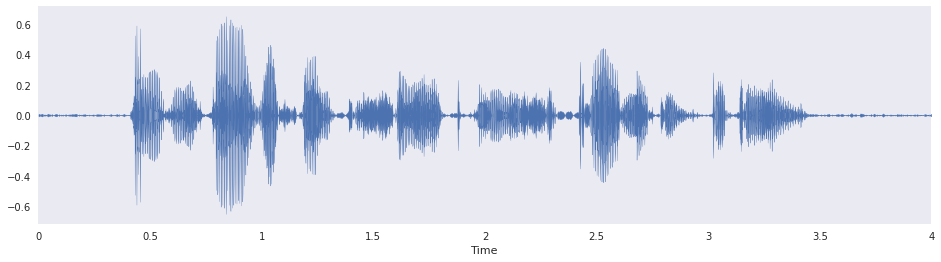

In [5]:
path = pysptk.util.example_audio_file() # from cmu_arctic
x, fs = librosa.load(path, sr=None)
x = x.astype(np.float64)

librosa.display.waveplot(x, sr=fs)
Audio(x, rate=fs)

In [6]:
frame_period = 5.0
hop_length = int(fs * frame_period * 0.001)
fftlen = pyworld.get_cheaptrick_fft_size(fs)

f0, timeaxis, sp, ap = decompose(x, fs, frame_period)

print(hop_length)
print(sp.shape)
print(fftlen)

80
(801, 513)
1024


### F0

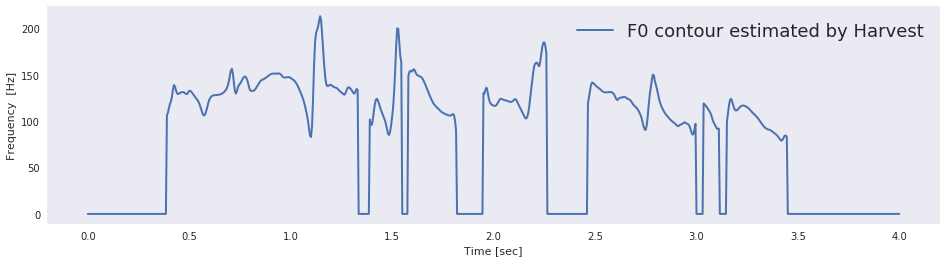

In [7]:
plot(timeaxis, f0, linewidth=2, label="F0 contour estimated by Harvest")
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend(fontsize=18);

### Spectral envelope

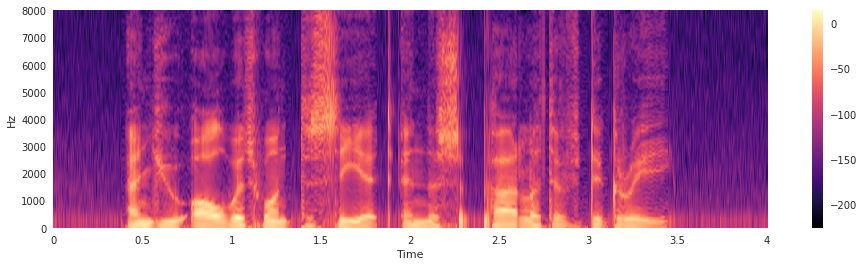

In [8]:
librosa.display.specshow(10*log(sp).T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()

### Aperiodicity

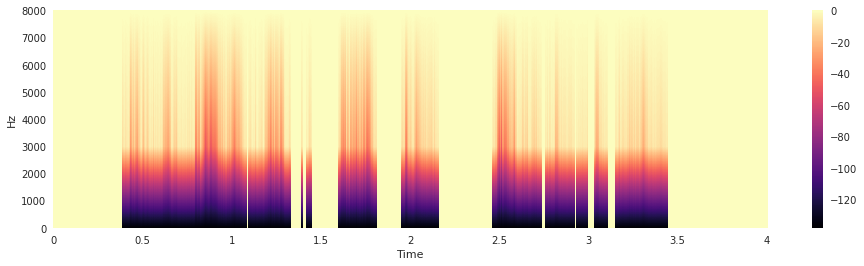

In [9]:
librosa.display.specshow(20*log(ap).T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
colorbar()

## 1. Synthesis from coded spectral envelope by WORLD

NMSE: 0.02875053773453773


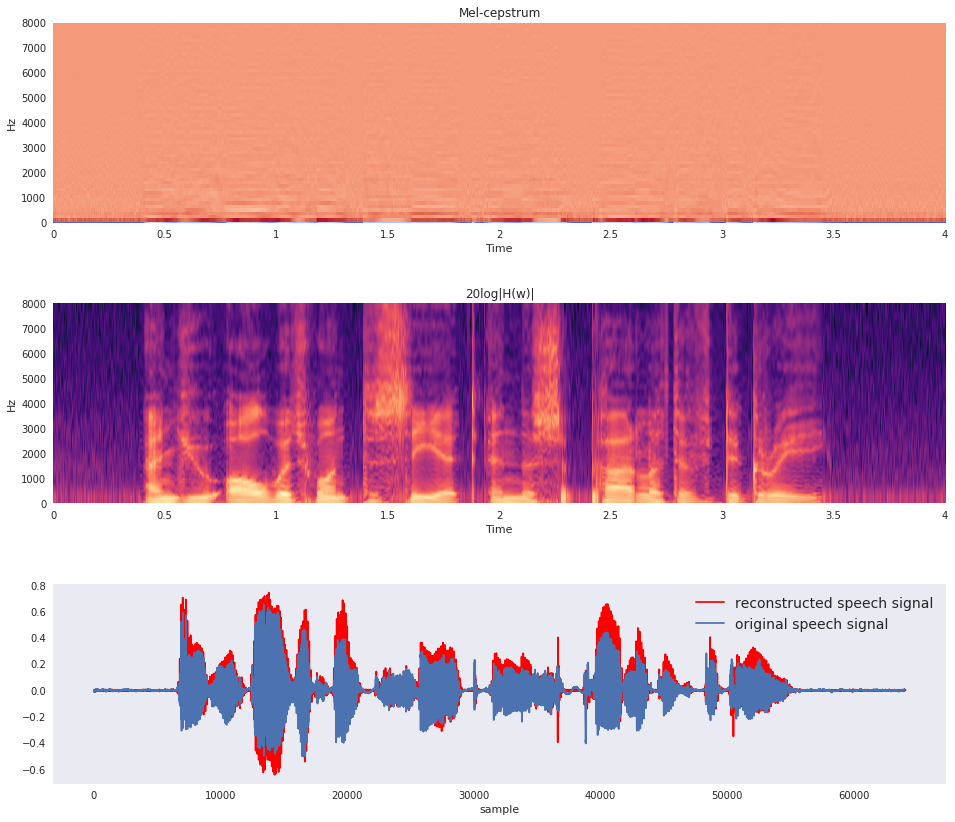

In [10]:
dim = 60
coded_sp = pyworld.code_spectral_envelope(sp, fs, dim)
decoded_sp = pyworld.decode_spectral_envelope(coded_sp, fs, fftlen)
y = pyworld.synthesize(f0, decoded_sp, ap, fs, frame_period)

nmse = np.linalg.norm(np.log(sp) - np.log(decoded_sp)) / np.linalg.norm(np.log(sp))
print("NMSE: {}".format(nmse))

vis(coded_sp, decoded_sp, x, y, "Mel-cepstrum")
Audio(y, rate=fs)

## 2. Synthesis from mel-cepstrum using pysptk

NMSE: 0.027851414093334522


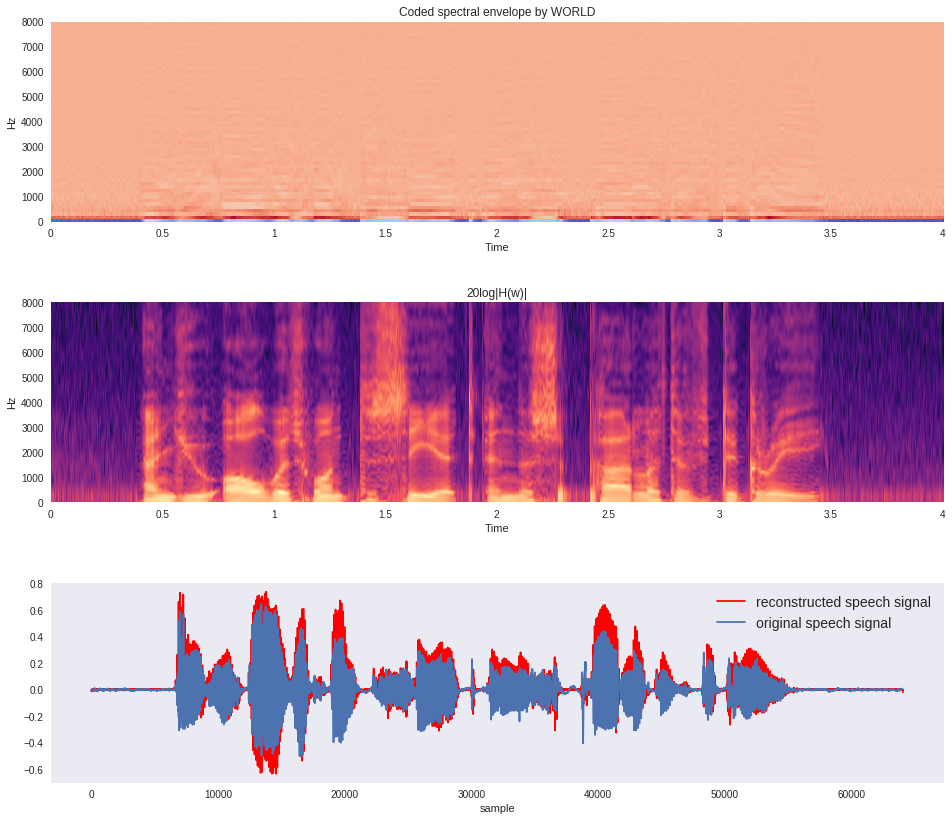

In [11]:
dim = 60
alpha = mcepalpha(fs)
mc = np.apply_along_axis(pysptk.sp2mc, 1, sp, dim-1, alpha)
approximate_sp = np.apply_along_axis(pysptk.mc2sp, 1, mc, alpha, fftlen)
y = pyworld.synthesize(f0, approximate_sp, ap, fs, frame_period)

nmse = np.linalg.norm(np.log(sp) - np.log(approximate_sp)) / np.linalg.norm(np.log(sp))
print("NMSE: {}".format(nmse))

vis(mc, approximate_sp, x, y, "Coded spectral envelope by WORLD")
Audio(y, rate=fs)